# GEOG 5160 6160 Lab 10 Recurrent neural networks

## Introduction

**THIS IS AN OPTIONAL LAB**

In this lab, we'll look at how to build a recurrent neural network using the Keras package. The example is modified from an example in Python from Jason Brownlee's blog on machine learning (https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/). 

You will need the file called *pollution.csv*, which should be available from Canvas with this document. Download this to your `datafiles` folder.

Let's start by loading some libraries we'll need for this lab:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

Next, we'll load the dataset and take a quick look at the first few lines:

In [2]:
# load dataset
dataset = pd.read_csv('../datafiles/pollution.csv', header=0, index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


The data are hourly pollution and weather measurements from the US embassy in Beijing for a period of 5 years. The goal will be to build a model that can do a step ahead prediction, i.e. can predict the PM2.5 concentration at any hour $t$ from the values of all the variables at previous hour $t-1$, *including the previous value of PM2.5*.

Let's make a couple of plots to see what the variables look like for the first year. We'll first convert this to a NumPy array (as these are a little easier for Keras to work with):

In [3]:
values = dataset.values

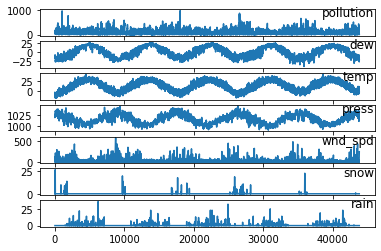

In [4]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

Before we can build a model there are a few things we'll need to do to process these data:

- Create lagged variables (i.e. the values of each variable one hour ahead of the target time)
- Encode the wind direction variable
- Normalize all the features
- Create a training and testing set

As we want to model pollution using the previous hour's features, we need to create a lagged version of each one. So for any given observation, we need the value of each feature from the previous hour. There's a couple of ways to do this, but we'll use a function that was create by Jason Brownlee to create a lagged dataset. This takes as arguments: the data set you want to alter, and the number of lags you need to create. It will return a new dataset consisting of the original values of each feature, plus new, time-lagged features. Note that it also removes any row with a missing value (lagged variables will have missing values for the first observations). 

A full description of what this function is doing can be found here:
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [5]:
from pandas import concat
from pandas import DataFrame
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We'll start by encoding the wind direction feature to integer values using scikit-learn's LabelEncoder(), then makes sure that everything is transformed to a floating point value:

In [6]:
from sklearn.preprocessing import LabelEncoder

 # Extract values to NumPy array
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

Next, we'll normalize the data to 0-1 range for training. We'll use scikit-learn's `MinMaxScaler` function to replace the original values with the transformed values. Normally, we'd only normalize the features, but as we are going to use the PM2.5 value from the previous time step as an additional feature, we need to normalize this as well. As this means we will be modeling the normalized PM2.5 values, we'll first store the minimum and maximum. This will allow us to back convert any predictions we make to parts per billion. 

In [7]:
pollution_min = np.min(values[:,0])
pollution_max = np.max(values[:,0])

print('PM2.5 Min: %.2f; Max: %.2f' % (pollution_min, pollution_max))

PM2.5 Min: 0.00; Max: 994.00


In [8]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Now, we'll pass the normalized features through the function to create lagged variables

In [9]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

And finally keep only the lagged features and the pollution:

In [10]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


If you look at the first few rows, you should see that the target (`var1(t)`) is now linked to the previous hour's pollution value `var1(t-1)` (and the other features).

The last thing we need to do is to create out training and testing sets. We'll keep the first two years for training, and the other three years for testing. Some things to note here:

- We generate an index for the samples that is the number of days in a year * the number of hours. Technically it should be one less than this as we will have lost the first row once we lagged the features
- The data are converted to a matrix form, then reshaped to a 3D array. As we are going to be fitting a recurrent neural network, we need to make sure the input tensor has the correct shape. RNNs use rank 3 tensors with a shape given by (`sample`, `timesteps`, `features`). Here, we only have a single time step, because we are only using the preceding hour as input. Ultimately we'll rely on the RNNs hidden state to 'remember' earlier information

In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 2 ## two years of data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17520, 1, 8) (17520,) (26279, 1, 8) (26279,)


## Model

### Dense network

Now let's put together a model. Before trying a recurrent NN, let's just build a standard dense network. This will allow us to test if the additional complexity of the RNN is worth it or not. There's only one small problem here. The dense network requires a rank 2 tensor or 2D array of features as input. In the step above, we created rank 3 tensors for use with a RNN: 

In [12]:
print(X_train.shape)
print(X_test.shape)

(17520, 1, 8)
(26279, 1, 8)


Fortunately, it is easy to change these back using the `reshape()` method:

In [13]:
X_train_flat = X_train.reshape(17520, 8)
X_test_flat = X_test.reshape(26279, 8)

Now let's divide these into a partial training set and validation set, with a year of data in each

In [14]:
n_train_hours = 365*24
X_train_flat_partial = X_train_flat[:n_train_hours, :]
y_train_partial = y_train[:n_train_hours]
X_val_flat = X_train_flat[n_train_hours:, :]
y_val = y_train[n_train_hours:]

As before, we build our model as a sequential series of layers. We have just a single hidden layer with 50 nodes and we'll use a default liner activation function. This feeds into a output layer with a single node to match the observed, non-lagged PM2.5 values.

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([                        
      layers.Dense(50, input_shape=(8,)),
      layers.Dense(1)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
None


Now let's compile this by adding an optimizer, loss function and performance metric. We'll use a different optimizer called Adam, which works well with large, noisy datasets (and is particularly efficient for deep learning).

In [16]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

And now we can train the network. We'll use a batch size of 64 as we have quite a lot of observations to work with, and run this for 50 epochs. We'll train on the first year of training data, and validate on the second.

In [17]:
# fit network
history = model.fit(X_train_flat_partial, y_train_partial, epochs=50, batch_size=64, 
                    validation_data=(X_val_flat, y_val), verbose=2, shuffle=False)

Train on 8760 samples, validate on 8760 samples
Epoch 1/50
8760/8760 - 2s - loss: 0.0047 - mae: 0.0492 - val_loss: 0.0093 - val_mae: 0.0785
Epoch 2/50
8760/8760 - 1s - loss: 0.0014 - mae: 0.0252 - val_loss: 0.0046 - val_mae: 0.0542
Epoch 3/50
8760/8760 - 1s - loss: 0.0011 - mae: 0.0202 - val_loss: 0.0023 - val_mae: 0.0374
Epoch 4/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0182 - val_loss: 0.0015 - val_mae: 0.0285
Epoch 5/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0171 - val_loss: 0.0012 - val_mae: 0.0253
Epoch 6/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0167 - val_loss: 0.0013 - val_mae: 0.0263
Epoch 7/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0165 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 8/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 9/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 10/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 11/50
8760/8760 - 1s - lo

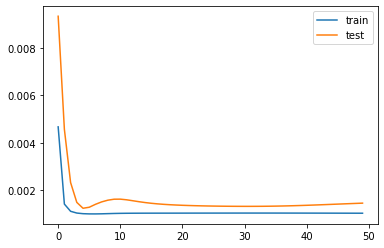

In [18]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The validation shows no sign of overfitting, but little improvement beyond about 35 epochs. Let's now build the full training model and evaluate:

In [19]:
model = models.Sequential([                        
      layers.Dense(50, input_shape=(8,)),
      layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train_flat, y_train, epochs=35, batch_size=64, 
                    verbose=0, shuffle=False)

We now evaluate on the test set

In [20]:
test_mse_score, test_mae_score = model.evaluate(X_test_flat, y_test, verbose=0)

In [21]:
print('Mean squared error: %.4f'
      % test_mse_score)
print('Mean absolute error: %.4f'
      % test_mae_score)

Mean squared error: 0.0011
Mean absolute error: 0.0237


As we had to normalize the PM2.5 values to use them as a lagged variable, the MAE is on this normalized scale. To get a better assessment of the model, we can calculate an error value by back-transforming the prediction. A simple function to back transform from a minmax scaling is:

In [22]:
def back_transform(data, data_min=0, data_max=1):
    return (data * (data_max - data_min)) + data_min

To get a back transformed MAE, we need to 

- Predict for the test set on the normalized scale
- Back transform these predictions
- Back transform the matching test labels (PM2.5 values)
- Calculate the mean absolute error

In [23]:
y_test_pred_norm = model.predict(X_test_flat)
y_test_pred_norm.shape

(26279, 1)

The output of the `predict()` method is a 2D array, so we'll need to reshape this to a 1D array to match the observed PM2.5 values

In [24]:
y_test_pred_norm = y_test_pred_norm.reshape(y_test.shape)

Now we can back transform these predictions (and the observed PM2.5 values from the test set)

In [25]:
y_test_pred = back_transform(y_test_pred_norm, pollution_min, pollution_max)
y_test_obs = back_transform(y_test, pollution_min, pollution_max)

And finally, calculate the MAE in ppb:

In [26]:
np.mean(np.abs(y_test_pred - y_test_obs))

23.528936

## LSTM 

Now let's build a recurrent neural network. We'll use a very similar structure to the previous model, but replace the hidden layer with a LSTM layer. This includes both the hidden state component and the carry track, allowing the model to propagate information over a large number of time steps. The input and output remain the same

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([                        
      layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
      layers.Dense(1)
])

In [28]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


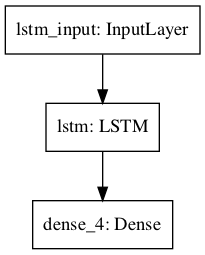

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [30]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Now let's train and validate. As this is a more complex algorithm, we'll train for 100 epochs. First divide the training data into training and validation. Note that now we need to keep this as a rank 3 tensor for the LSTM layer

In [31]:
n_train_hours = 365*24
X_train_partial = X_train[:n_train_hours, :, :]
y_train_partial = y_train[:n_train_hours]
X_val = X_train[n_train_hours:, :, :]
y_val = y_train[n_train_hours:]

In [32]:
# fit network
history = model.fit(X_train_partial, y_train_partial, epochs=100, batch_size=64, 
                    validation_data=(X_val, y_val), verbose=1, shuffle=False)

Train on 8760 samples, validate on 8760 samples
Epoch 1/100
8760/8760 [==============================] - 6s 734us/sample - loss: 0.0070 - mae: 0.0620 - val_loss: 0.0093 - val_mae: 0.0850
Epoch 2/100
8760/8760 [==============================] - 2s 190us/sample - loss: 0.0035 - mae: 0.0424 - val_loss: 0.0121 - val_mae: 0.0933
Epoch 3/100
8760/8760 [==============================] - 2s 194us/sample - loss: 0.0019 - mae: 0.0304 - val_loss: 0.0124 - val_mae: 0.0914
Epoch 4/100
8760/8760 [==============================] - 2s 197us/sample - loss: 0.0014 - mae: 0.0252 - val_loss: 0.0102 - val_mae: 0.0819
Epoch 5/100
8760/8760 [==============================] - 2s 197us/sample - loss: 0.0012 - mae: 0.0221 - val_loss: 0.0078 - val_mae: 0.0715
Epoch 6/100
8760/8760 [==============================] - 2s 202us/sample - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0062 - val_mae: 0.0635
Epoch 7/100
8760/8760 [==============================] - 2s 199us/sample - loss: 0.0011 - mae: 0.0186 - val_loss: 0.00

Epoch 58/100
8760/8760 [==============================] - 2s 191us/sample - loss: 9.5510e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 59/100
8760/8760 [==============================] - 2s 195us/sample - loss: 9.5468e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 60/100
8760/8760 [==============================] - 2s 180us/sample - loss: 9.5426e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 61/100
8760/8760 [==============================] - 2s 174us/sample - loss: 9.5385e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0223
Epoch 62/100
8760/8760 [==============================] - 2s 182us/sample - loss: 9.5344e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0222
Epoch 63/100
8760/8760 [==============================] - 2s 191us/sample - loss: 9.5303e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0221
Epoch 64/100
8760/8760 [==============================] - 2s 197us/sample - loss: 9.5263e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae:

Plot the training history

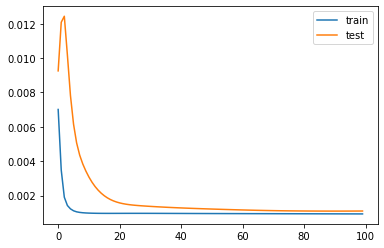

In [33]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The results suggest that the model converges at around 60 epochs. Let's train a final model and evaluate.

In [34]:
model = models.Sequential([                        
      layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
      layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=60, batch_size=64, 
                    verbose=1, shuffle=False)

Train on 17520 samples
Epoch 1/60
17520/17520 [==============================] - 7s 386us/sample - loss: 0.0061 - mae: 0.0577
Epoch 2/60
17520/17520 [==============================] - 2s 126us/sample - loss: 0.0018 - mae: 0.0302
Epoch 3/60
17520/17520 [==============================] - 2s 134us/sample - loss: 9.9177e-04 - mae: 0.0196
Epoch 4/60
17520/17520 [==============================] - 2s 132us/sample - loss: 8.9278e-04 - mae: 0.0171
Epoch 5/60
17520/17520 [==============================] - 2s 129us/sample - loss: 8.6476e-04 - mae: 0.0162
Epoch 6/60
17520/17520 [==============================] - 2s 137us/sample - loss: 8.5453e-04 - mae: 0.0158
Epoch 7/60
17520/17520 [==============================] - 2s 129us/sample - loss: 8.4903e-04 - mae: 0.0155
Epoch 8/60
17520/17520 [==============================] - 2s 132us/sample - loss: 8.4562e-04 - mae: 0.0154
Epoch 9/60
17520/17520 [==============================] - 3s 149us/sample - loss: 8.4426e-04 - mae: 0.0154
Epoch 10/60
17520/1752

We now evaluate on the test set

In [35]:
test_mse_score, test_mae_score = model.evaluate(X_test, y_test, verbose=0)

In [36]:
print('Mean squared error: %.4f'
      % test_mse_score)
print('Mean absolute error: %.4f'
      % test_mae_score)

Mean squared error: 0.0009
Mean absolute error: 0.0187


And let's calculate the error after back-transformation

In [37]:
y_test_pred_norm = model.predict(X_test)
y_test_pred_norm.shape

y_test_pred_norm = y_test_pred_norm.reshape(y_test.shape)

y_test_pred = back_transform(y_test_pred_norm, pollution_min, pollution_max)
y_test_obs = back_transform(y_test, pollution_min, pollution_max)

np.mean(np.abs(y_test_pred - y_test_obs))

18.609028

This gives a reduction in the MAE of about 2-3 ppb, a decrease of around 10% relative to the dense network model. 

## Extending the model
Note that it is relatively easy to extend this model to incorporate more lags. The following code shows how to make a dataset where the PM2.5 value is modeled using the 3 previous time steps:

In [38]:
reframed = series_to_supervised(scaled, 3, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[25,26,27,28,29,30,31]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var8(t-2)  var1(t-1)  \
3   0.000000        0.0   0.148893   0.367647  ...        0.0   0.159960   
4   0.000000        0.0   0.159960   0.426471  ...        0.0   0.182093   
5   0.000000        0.0   0.182093   0.485294  ...        0.0   0.138833   
6   0.037037        0.0   0.138833   0.485294  ...        0.0   0.109658   
7   0.074074        0.0   0.109658   0.485294  ...        0.0   0.105634   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
3   0.426471   0.229508   0.545454   0.666667

Note that the model will still be defined in the same way, except that the shape of the input tensor will be (?, 3, 8). 

In [39]:
model = models.Sequential([                        
      layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
      layers.Dense(1)
])